# Vehicle Detection Project

## The goals / steps of this project are the following:

#### Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
#### Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
####  Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
#### Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
#### Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
#### Estimate a bounding box for vehicles detected.


###### Import necessay functions

In [5]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn import svm, grid_search
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog


from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

  "This module will be removed in 0.20.", DeprecationWarning)

  DeprecationWarning)



## Define functions to Extract Features and predict the vehicle using the classifier 

In [6]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        #image = mpimg.imread(file)
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [7]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)



In [8]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    


## Visualizing Hog Features for a random car and a non car image

Random Car and Non Car images and its hog features


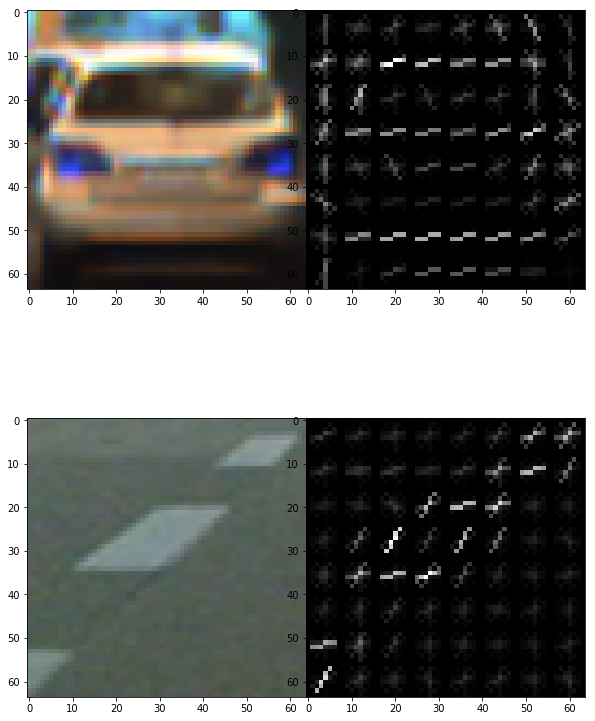

In [34]:
fig, axs = plt.subplots(2,2, figsize=(10, 15))
fig.subplots_adjust(hspace = .0002, wspace=.001)

import random

print("Random Car and Non Car images and its hog features")
r = random.randint(0,8000)
img = cv2.imread(cars[r])

axs[0][0].imshow(img,cmap = 'gray')
#plt.show()

img = cv2.cvtColor(img,cv2.COLOR_BGR2LUV)


hog_features, hog_img = get_hog_features(img[:,:,0], 9, 8 , 2, 
                        vis=True, feature_vec=True)

axs[0][1].imshow(hog_img,cmap='gray')
#plt.show()


r = random.randint(0,8000)
img = cv2.imread(notcars[r])

axs[1][0].imshow(img,cmap='gray')
#plt.show()

img = cv2.cvtColor(img,cv2.COLOR_BGR2LUV)



hog_features, hog_img = get_hog_features(img[:,:,0], 9, 8 , 2, 
                        vis=True, feature_vec=True)

axs[1][1].imshow(hog_img, cmap = 'gray')
#plt.show()


## Load the Car and Non car images.

In [9]:
# Read in cars and notcars


cars = []
notcars = []


car = glob.glob('vehicles/*/*.png')
not_car = glob.glob('non-vehicles/*/*.png')

#print(not_car)
for nc in not_car:
    notcars.append(nc)

for c in car:
    cars.append(c)

print(len(cars))
print(len(notcars))



8792
8968


##### Make the car and non car images spread equally. 
##### Give the parameters to be used for extracting features for each image.
##### Extract features for each image.
##### Split the data into training and test data.
##### Scale the data and fit it.

In [10]:

sample_size = 8500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
 # Min and max in y to search in slide_window()

print("Extracting features started...")

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

print("Splitting Data...")

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print("Scaling....")

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))




Extracting features started...
Splitting Data...
Scaling....
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580


## Train the classifier

In [11]:
print("Training started")
# Check the training time for the SVC
t=time.time()

#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

clf = svm.SVC(kernel='rbf',C=5)

#svr = svm.SVC()
#clf = grid_search.GridSearchCV(svr, parameters)

clf.fit(X_train, y_train)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC

# Check the prediction time for a single sample
#t=time.time()

#print("The best parameter values are",clf.best_params_)


Training started
79.9 Seconds to train SVC...


## Test the accuracy

In [12]:
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9938


## Visualizing the Sliding windows used

Sliding window 1 Used


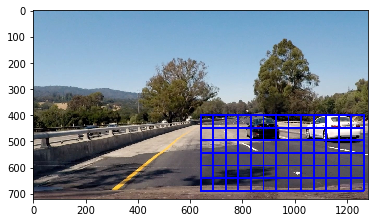

sliding window 2 Used


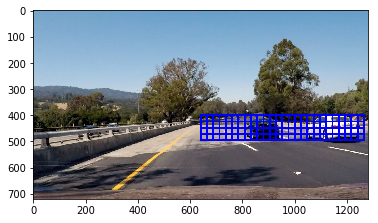

In [35]:
# Visualizing the sliding windows in use on a test image:

image = image = mpimg.imread('test_images/test4.jpg')
x_start_stop = [640,1280]
y_start_stop = [400, 720]
windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

img_out = draw_boxes(image,windows)

print("Sliding window 1 Used")
plt.imshow(img_out)
plt.show()

x_start_stop = [640,1280]
y_start_stop = [400, 500]
windows2 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
    xy_window=(48, 48), xy_overlap=(0.5, 0.5))

img_out2 = draw_boxes(image,windows2)

print("sliding window 2 Used")
plt.imshow(img_out2)
plt.show()

## Implemet Sliding window

In [13]:
def get_cars_coords(image):
    
    x_start_stop = [640,1280]
    y_start_stop = [400, 720]
    windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)     

    x_start_stop = [640,1280]
    y_start_stop = [400, 500]
    windows2 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(48, 48), xy_overlap=(0.5, 0.5))

    hot_windows2 = search_windows(image, windows2, clf, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)   

    car_found = tuple(hot_windows) + tuple(hot_windows2) #+ tuple(hot_windows3)

    window_img = draw_boxes(image, car_found, color=(0, 0, 255), thick=6)
    
    return window_img, car_found


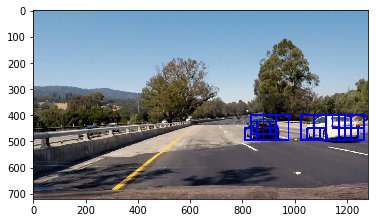

In [14]:
image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)

window_img, car_found = get_cars_coords(image)

plt.imshow(window_img)
plt.show()

## Visualizing afterApplying Sliding window

Visualising the all test images after finding the vehicles along with the original images


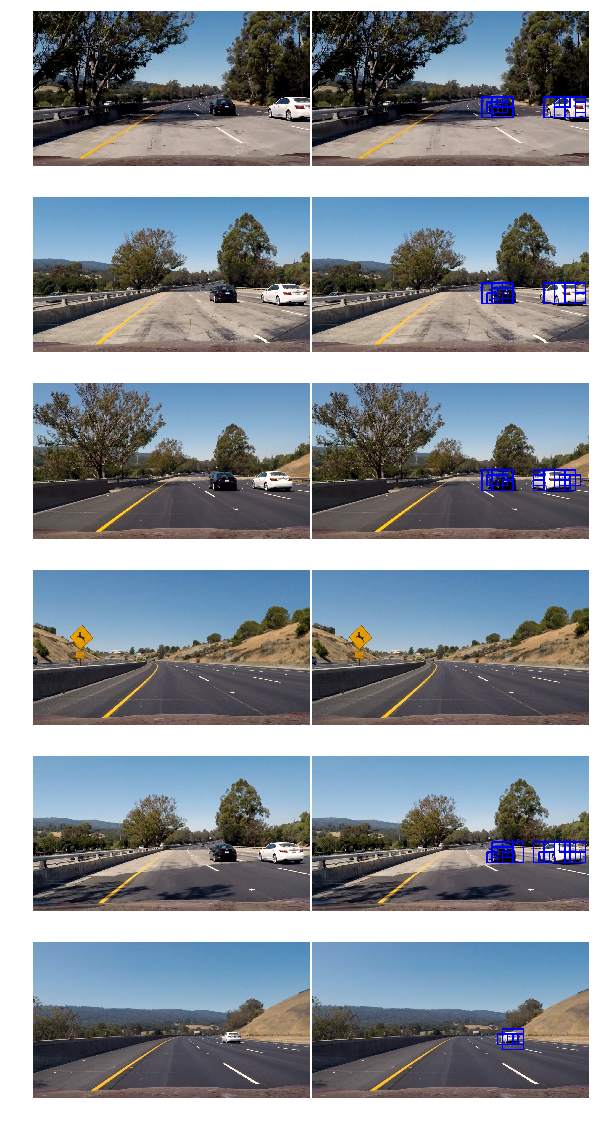

In [37]:
images = glob.glob('./test_images/*.jpg')
             
print("Visualising the all test images after finding the vehicles along with the original images")
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    window_img, car_found = get_cars_coords(img)
    
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
    i += 1
    axs[i].imshow(window_img, cmap='gray')
    axs[i].axis('off')
    i += 1

## Defining Heatmap to avoid duplicate and reduce false positives

In [15]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



## Visualizing after applying heatmap

Visualising the all test images after finding the vehicles, applying heat map and after the heat map.


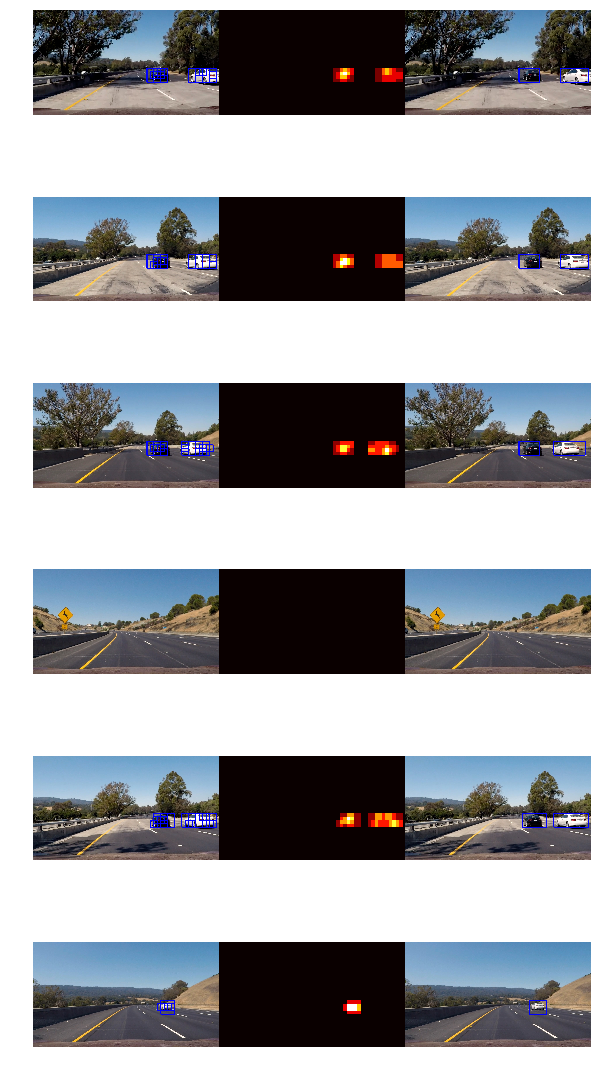

In [38]:
images = glob.glob('./test_images/*.jpg')

print("Visualising the all test images after finding the vehicles, applying heat map and after the heat map.")
# Set up plot

fig, axs = plt.subplots(len(images),3, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

windows_images = []
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    window_img, car_found = get_cars_coords(img)
    
    heat = np.zeros_like(window_img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,car_found)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    axs[i].imshow(window_img, cmap='gray')
    axs[i].axis('off')
    i += 1
    
    axs[i].imshow(heatmap, cmap='hot')
    axs[i].axis('off')
    i += 1
    
    axs[i].imshow(draw_img, cmap='gray')
    axs[i].axis('off')
    i += 1

## Defining the final pipeline for vehicle detection

In [19]:
def pipeline_vehicle_detection(img):
    global frames
    image = np.copy(img)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #image = image.astype(np.float32)/255

    draw_img = image

    window_img, car_found = get_cars_coords(image)
    
    heat = np.zeros_like(window_img[:,:,0]).astype(np.float)
        # Add heat to each box in box list
    heat = add_heat(heat,car_found)

    if(len(frames)<10):
        frames.append(heat)
    
    else:
        frames.append(heat)
        heat = np.sum(frames, axis=0)
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,8)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img


In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
from collections import deque

frames = deque(maxlen=10)

output = 'output_video.mp4'

clip3 = VideoFileClip('project_video.mp4')#.subclip(26,30)
output_clip = clip3.fl_image(pipeline)
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video op_luv_0_96_48_8_final.mp4
[MoviePy] Writing video op_luv_0_96_48_8_final.mp4


100%|█████████▉| 1260/1261 [31:31<00:01,  1.51s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: op_luv_0_96_48_8_final.mp4 

CPU times: user 31min 9s, sys: 21 s, total: 31min 30s
Wall time: 31min 32s


## Visualizing the Output Video

In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

# Optional Challenge 

## Combining the lane line finding with the above found vehicle detection

In [20]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import pickle
%matplotlib inline

In [21]:
nx = 9
ny = 6


## Loading the Calibration co-ordinates from pickle file

In [22]:
def get_coords():
    filename = 'cam_calib_coords.sav'
    cam_calib_coords = pickle.load(open(filename,'rb'))
    mtx = cam_calib_coords["mtx"]
    dist = cam_calib_coords["dist"]
    return mtx, dist

## Defining all the necessary methods to run the lane finding model

In [23]:
def gradx_thresh(img, sobel_kernel=3, thresh=(0,255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x
    # 3) Take the absolute value of the derivative
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)


    #print("sobel", sobel)
    abs_sobel = np.absolute(sobel)
    #print("abs", abs_sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    #print("sc",scaled_sobel)
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    
    return sxbinary

def hls_s_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    S = hls[:,:,2]

    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    return binary

def lab_b_select(img, thresh=(0,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary = np.zeros_like(lab_b)
    binary[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary

def hls_l_select(img, thresh=(220, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    binary = np.zeros_like(hls_l)
    binary[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary

def get_binary_image(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    gradx = gradx_thresh(img, sobel_kernel=3, thresh=(20, 100))

    #s_binary = hls_s_select(img,thresh=(170, 255))
    
    b_binary = lab_b_select(img,thresh=(190,255))
    
    l_binary = hls_l_select(img)

    out = np.zeros_like(gradx)
    out[ (gradx == 1) | (l_binary == 1) | (b_binary == 1)] = 1
    return out

def perspective_transform(image):
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_size = (image.shape[1], image.shape[0])
    
    bottom_left = [220,720]
    bottom_right = [1110, 720]
    top_left = [570, 470]
    top_right = [722, 470]

    src = np.float32([bottom_left,bottom_right,top_right,top_left])
    
    
    bottom_left = [320,720]
    bottom_right = [920, 720]
    top_left = [320, 1]
    top_right = [920, 1]

    dst = np.float32([bottom_left,bottom_right,top_right,top_left])
    
    #src = np.float32(
     #   [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
      #  [((img_size[0] / 6) - 10), img_size[1]-40],
       # [(img_size[0] * 5 / 6) + 60, img_size[1]-40],
        #[(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    #print(src)
    #dst = np.float32(
     #   [[(img_size[0] / 4), 0],
      #  [(img_size[0] / 4), img_size[1]],
       # [(img_size[0] * 3 / 4), img_size[1]],
        #[(img_size[0] * 3 / 4), 0]])
    #print(dst)
    M = cv2.getPerspectiveTransform(src,dst)
    M_Inv = cv2.getPerspectiveTransform(dst,src)

    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M_Inv

def basic_transformations(img,mtx,dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    warped, M_Inv = perspective_transform(dst)
    
    binary_warped = get_binary_image(warped)
    
    return binary_warped, M_Inv


    

In [24]:
def new_fit(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    #midpoint = np.int(histogram.shape[0]/2)
    #leftx_base = np.argmax(histogram[:midpoint])
    #rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    #print(binary_warped.shape)

    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    #print(nonzerox)
    #print(nonzeroy)
    #break
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    visualize = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        #print(window)
        #print(window_height)
        #break
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        visualize.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        
        #print(((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        #(nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0])
        #break
        #print(((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &     (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero())
        #print(nonzeroy[((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]])

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

        #print(nonzerox[good_left_inds])
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        #print(nonzerox[good_right_inds])
        #break

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, left_lane_inds, right_lane_inds,histogram,visualize

def use_prev_fit(binary_warped,left_fit,right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit, left_lane_inds, right_lane_inds

def calc_rad_center(img,left_fit, right_fit, left_lane_inds, right_lane_inds):    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    #size = img.shape[0]
    #ploty = np.linspace(0, size-1, size)
    
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    #leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    #rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    #print(len(leftx))
    #print(left_lane_inds.shape)
    #print((ploty*ym_per_pix).shape[0], (leftx*xm_per_pix).shape[0])
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    y_evall = np.max(lefty)
    y_evalr = np.max(righty)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_evall*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_evalr*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    center_dist = 0
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if right_fit is not None and left_fit is not None:
        car_position = img.shape[1]/2
        h = img.shape[0]
        l_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        r_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        #print(lane_center_position,"<---- center")
        center_dist = abs((car_position - lane_center_position) * xm_per_pix)

        
    return left_curverad, right_curverad, center_dist

def fill_color2original_image(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img)#.astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(255,0,0), thickness=15)
    
    #plt.imshow(color_warp,cmap='gray')
    #plt.show()
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    #plt.imshow(newwarp,cmap='gray')
    #plt.show()
    
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result


def write_rad_center(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_TRIPLEX
    text = 'Curve radius: ' + '{:04.4f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)

    text = 'Center offset:  ' + '{:04.4f}'.format(center_dist)
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img



In [25]:

mtx, dist = get_coords()
#print("obj",objpoints,"img",imgpoints)

In [26]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False 
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        self.c = 0
        
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to 5
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit
                self.detected = False
            else:
                self.detected = True
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

In [27]:
def pipeline_draw_lane_line(img):
    

    binary_warped, M_Inv = basic_transformations(img,mtx,dist)
    
    if not l_line.detected or not r_line.detected:
        left_fit, right_fit, left_lane_inds, right_lane_inds,histogram,visualize = new_fit(binary_warped)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = use_prev_fit(binary_warped,l_line.best_fit, r_line.best_fit)
    
    
        # invalidate both fits if the difference in their x-intercepts isn't around +-100 compared with 350 px
    if left_fit is not None and right_fit is not None:
        
        h = img.shape[0]
        l_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        r_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(left_fit, left_lane_inds)
    r_line.add_fit(right_fit, right_lane_inds)
    
    
    if l_line.best_fit is not None and r_line.best_fit is not None:

        out1 = fill_color2original_image(img, binary_warped, left_fit, right_fit, M_Inv)

        rad_l, rad_r, center = calc_rad_center(binary_warped,left_fit, right_fit, left_lane_inds, right_lane_inds)

        out2 = write_rad_center(out1, (rad_l+rad_r)/2, center)

    else:
        out2 = img
    
    return out2

In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Define the pipeline to use both the pipelines to detect lane lines as well as vehicles

In [29]:
def pipeline(img):
    
    out_lane_line = pipeline_draw_lane_line(img)
    out_vehicle_lane_line_combined = pipeline_vehicle_detection(out_lane_line)
    
    return out_vehicle_lane_line_combined

In [32]:
from collections import deque

frames = deque(maxlen=10)

l_line = Line()
r_line = Line()

output = "out_vehicle_lane_line_combined.mp4"

clip1 = VideoFileClip("project_video.mp4")#.subclip(10,15)#(38,46)

clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!

%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video out_vehicle_lane_line_combined.mp4
[MoviePy] Writing video out_vehicle_lane_line_combined.mp4


100%|█████████▉| 1260/1261 [33:03<00:01,  1.58s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_vehicle_lane_line_combined.mp4 

CPU times: user 37min 28s, sys: 21.6 s, total: 37min 49s
Wall time: 33min 4s


# Visualizing the combined output

In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))